In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import DistanceMetric

import seaborn as sns

import uuid

import itertools

In [2]:
df = pd.read_csv("jsondata_sing_plur.csv")
df.head()

,filename,lon,lat,result_string,singular,plural
0,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737938,10.795654,"other.dump 1,",0,1
1,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1
2,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1
3,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1
4,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.739403,10.796682,"other.dump 1,",0,1


- ameryki
- azja+australia
- europa 50%
- afryka

In [12]:
def europe(lat, lon):
    # 35.452080478536786, -16.6356733107719
    # 71.07063554548382, 37.32917137447141
    return (lat > 35) & (lat < 71) & (lon > -16) & (lon < 37)

def americas(lat, lon):
    # 71.54004014207757, -168.68645481971575
    # -57.772478690985004, -24.54582879003382
    #take only lon
    return (lon > -169) & (lon < -24)

def asia_australia(lat, lon):
    # 71.03249166206427, 43.30573267114566
    # 70.45278714274222, -170.092702288161
    #take only lon, lat > 8.280510727790247
    return ((lon > 43) | (lon < -169)) & (lat > 8)

def africa_rest(lat, lon):
    # the rest
    return (~europe(lat,lon)) & (~americas(lat,lon)) & (~(asia_australia(lat,lon)))

In [13]:
print("europe",len(df[europe(df.lat,df.lon)]))
print("americas",len(df[americas(df.lat,df.lon)]))
print("asia_australia",len(df[asia_australia(df.lat,df.lon)]))
print("africa_rest",len(df[africa_rest(df.lat,df.lon)]))

europe 48563
americas 1869
asia_australia 334
africa_rest 4242


take 40% of europe for simplicity

In [17]:
df_eu = df[europe(df.lat,df.lon)].sample(frac=0.4).reset_index()
df_am = df[americas(df.lat,df.lon)].reset_index()
df_aa = df[asia_australia(df.lat,df.lon)].reset_index()
df_af = df[africa_rest(df.lat,df.lon)].reset_index()

In [21]:
%%time
dist = DistanceMetric.get_metric('haversine')

for df_sel in [df_eu, df_am, df_aa, df_af]:
    df_sel['lat_radians'] = np.radians(df_sel['lat'])
    df_sel['lon_radians'] = np.radians(df_sel['lon'])

    dist_matrix = dist.pairwise(df_sel[['lat_radians','lon_radians']].to_numpy())*6373000
    
    clusterer = AgglomerativeClustering(linkage = "complete", distance_threshold = 20, n_clusters = None,
                                   affinity = "precomputed")
    clust = clusterer.fit(dist_matrix)
    labels = clusterer.labels_
    np.unique(labels).shape
    df_sel['cluster'] = labels

CPU times: user 38.2 s, sys: 2.37 s, total: 40.5 s
Wall time: 40.4 s


In [30]:
for df_sel in [df_eu, df_am, df_aa, df_af]:
    uuids = {k: str(uuid.uuid4()) for k in df_sel.cluster.unique()}
    df_sel["cluster_uuid"] = df_sel.cluster.apply(lambda x: uuids[x])

In [35]:
df = pd.concat([df_eu, df_am, df_aa, df_af]).set_index("index").sort_values("index")
df

,filename,lon,lat,result_string,singular,plural,lat_radians,lon_radians,cluster,cluster_uuid
index,,,,,,,,,,
0,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737938,10.795654,"other.dump 1,",0,1,0.188420,1.862928,23,9e4301ec-aabb-4fec-9924-43291b98f88f
1,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1,0.188420,1.862929,23,9e4301ec-aabb-4fec-9924-43291b98f88f
2,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1,0.188420,1.862929,23,9e4301ec-aabb-4fec-9924-43291b98f88f
3,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1,0.188420,1.862929,23,9e4301ec-aabb-4fec-9924-43291b98f88f
4,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.739403,10.796682,"other.dump 1,",0,1,0.188438,1.862954,70,54895e0b-96aa-48bf-b235-40fe6cbe770e
...,...,...,...,...,...,...,...,...,...,...
54999,https://olm-s3.s3.eu-west-1.amazonaws.com/2021...,6.148867,52.790763,"softdrinks.plastic_cups 1,brands.mcdonalds 1,",0,1,0.921373,0.107318,5836,83477fe1-b579-4e74-adfe-a6265114a46c
55002,https://olm-s3.s3.eu-west-1.amazonaws.com/2021...,6.145114,52.794792,"smoking.butts 1,",1,0,0.921443,0.107252,261,edba7d27-8e6f-41f2-bb17-6c723a69d964
55004,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,-121.198683,36.481358,"other.metal 1,",1,0,0.636720,-2.115316,564,5d60ea6d-d21b-4ba1-8980-f508b2de65ea


In [36]:
df.to_csv("data_with_cluster_uuids.csv")

# prep summary 

chcę mieć kolumny:

cluster_uuid, res_string_connected, centr_coordinates, is_dump

In [38]:
mapping = pd.read_csv("single_multiple_mapping.csv", names=["cat", "class"])
mapping_dict = mapping.set_index("cat").to_dict()["class"]

In [39]:
df["result_list"] = df.result_string.str.replace(".", "@").apply(lambda x: x[:-1].split(","))
df["result_dict"] = df.result_string.apply(lambda x: {elem.split(" ")[0]:elem.split(" ")[1] for elem in str(x)[:-1].split(",")})
df.result_dict

index
0                                      {'other.dump': '1'}
1                                      {'other.dump': '1'}
2                                      {'other.dump': '1'}
3                                      {'other.dump': '1'}
4                                      {'other.dump': '1'}
                               ...                        
54999    {'softdrinks.plastic_cups': '1', 'brands.mcdon...
55002                               {'smoking.butts': '1'}
55004                                 {'other.metal': '1'}
55005    {'softdrinks.energy_can': '1', 'brands.redbull...
55007                              {'other.balloons': '1'}
Name: result_dict, Length: 25870, dtype: object

In [40]:
def count_singular_plural(dic, class_code):
    singular_count = 0
    for cat in dic:
        if cat.startswith("brands"):
            continue
        if mapping_dict[cat] == class_code:
            singular_count += int(dic[cat])
    return singular_count

df["singular"] = df.result_dict.apply(lambda x: count_singular_plural(x, class_code=1))
df["plural"] = df.result_dict.apply(lambda x: count_singular_plural(x, class_code=2))
df

,filename,lon,lat,result_string,singular,plural,lat_radians,lon_radians,cluster,cluster_uuid,result_list,result_dict
index,,,,,,,,,,,,
0,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737938,10.795654,"other.dump 1,",0,1,0.188420,1.862928,23,9e4301ec-aabb-4fec-9924-43291b98f88f,[other@dump 1],{'other.dump': '1'}
1,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1,0.188420,1.862929,23,9e4301ec-aabb-4fec-9924-43291b98f88f,[other@dump 1],{'other.dump': '1'}
2,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1,0.188420,1.862929,23,9e4301ec-aabb-4fec-9924-43291b98f88f,[other@dump 1],{'other.dump': '1'}
3,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.737968,10.795668,"other.dump 1,",0,1,0.188420,1.862929,23,9e4301ec-aabb-4fec-9924-43291b98f88f,[other@dump 1],{'other.dump': '1'}
4,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,106.739403,10.796682,"other.dump 1,",0,1,0.188438,1.862954,70,54895e0b-96aa-48bf-b235-40fe6cbe770e,[other@dump 1],{'other.dump': '1'}
...,...,...,...,...,...,...,...,...,...,...,...,...
54999,https://olm-s3.s3.eu-west-1.amazonaws.com/2021...,6.148867,52.790763,"softdrinks.plastic_cups 1,brands.mcdonalds 1,",0,1,0.921373,0.107318,5836,83477fe1-b579-4e74-adfe-a6265114a46c,"[softdrinks@plastic_cups 1, brands@mcdonalds 1]","{'softdrinks.plastic_cups': '1', 'brands.mcdon..."
55002,https://olm-s3.s3.eu-west-1.amazonaws.com/2021...,6.145114,52.794792,"smoking.butts 1,",1,0,0.921443,0.107252,261,edba7d27-8e6f-41f2-bb17-6c723a69d964,[smoking@butts 1],{'smoking.butts': '1'}
55004,https://olm-s3.s3.eu-west-1.amazonaws.com/2020...,-121.198683,36.481358,"other.metal 1,",1,0,0.636720,-2.115316,564,5d60ea6d-d21b-4ba1-8980-f508b2de65ea,[other@metal 1],{'other.metal': '1'}


In [59]:
def summarize(cluster):
    result = {}
    result["center_lat"] = cluster.lat.mean()
    result["center_lon"] = cluster.lon.mean()
    result["singular"] = cluster.singular.sum()
    result["plural"] = cluster.plural.sum()
    
    # combine dictionaries in cluster
    final_dic = {}
    for dic in cluster.result_dict:
        for k in dic.keys():
            final_dic[k] = int(final_dic.get(k, 0)) + int(dic.get(k, 0))
    result["combined_dict"] = final_dic
    
    return pd.Series(result, index=["center_lat", "center_lon", "singular", "plural", "combined_dict"])

result = df[["cluster_uuid", "lat", "lon", "singular", "plural", "result_dict"]].groupby("cluster_uuid").apply(summarize)
result

,center_lat,center_lon,singular,plural,combined_dict
cluster_uuid,,,,,
00075db9-825f-4fc1-8114-c6613070be4b,52.681609,-3.115059,7,0,"{'smoking.butts': 4, 'food.paperFoodPackaging'..."
0007a1bb-0f19-4118-a051-e4f8071db812,51.411778,-3.490925,0,1,"{'food.sweetWrappers': 1, 'brands.cadburys': 1}"
000be939-1425-47e7-9524-dd10db82b76f,52.160488,-3.417397,1,2,"{'food.sweetWrappers': 2, 'other.plastic': 1, ..."
000ef249-70d8-4a66-8e50-ab6e0f1ebd27,50.733551,-1.726677,13,1,"{'other.plastic': 8, 'food.foodOther': 2, 'san..."
00121716-3590-4f30-92b0-a216d40a33ff,52.658936,-3.142626,25,0,"{'food.foodOther': 1, 'smoking.butts': 17, 'sm..."
...,...,...,...,...,...
ffde3718-6a52-47ee-81b2-5e6509c96b01,52.247687,-3.379882,2,0,"{'other.dogshit': 1, 'smoking.butts': 1}"
ffe1fa45-255d-4bed-9f1f-19972fb6c38a,52.503922,4.775872,1,0,{'alcohol.beerCan': 1}
ffe6690f-0fa4-4020-9be8-444e0bf6c16b,-30.111194,153.193431,5,2,"{'other.other': 1, 'smoking.butts': 1, 'other...."


# What threshold to pick?

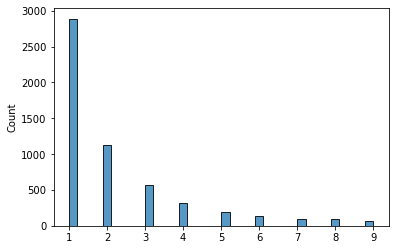

In [84]:
g = sns.histplot(list(result[(result.plural == 0) & (result.singular < 10) & (result.singular >0)].singular))

In [89]:
THRESHOLD = 6

result["is_dump"] = result.apply(lambda cl: True if cl["plural"] > 0 else True if cl["singular"] > THRESHOLD else False, axis=1)
result

,center_lat,center_lon,singular,plural,combined_dict,is_dump
cluster_uuid,,,,,,
00075db9-825f-4fc1-8114-c6613070be4b,52.681609,-3.115059,7,0,"{'smoking.butts': 4, 'food.paperFoodPackaging'...",True
0007a1bb-0f19-4118-a051-e4f8071db812,51.411778,-3.490925,0,1,"{'food.sweetWrappers': 1, 'brands.cadburys': 1}",True
000be939-1425-47e7-9524-dd10db82b76f,52.160488,-3.417397,1,2,"{'food.sweetWrappers': 2, 'other.plastic': 1, ...",True
000ef249-70d8-4a66-8e50-ab6e0f1ebd27,50.733551,-1.726677,13,1,"{'other.plastic': 8, 'food.foodOther': 2, 'san...",True
00121716-3590-4f30-92b0-a216d40a33ff,52.658936,-3.142626,25,0,"{'food.foodOther': 1, 'smoking.butts': 17, 'sm...",True
...,...,...,...,...,...,...
ffde3718-6a52-47ee-81b2-5e6509c96b01,52.247687,-3.379882,2,0,"{'other.dogshit': 1, 'smoking.butts': 1}",False
ffe1fa45-255d-4bed-9f1f-19972fb6c38a,52.503922,4.775872,1,0,{'alcohol.beerCan': 1},False
ffe6690f-0fa4-4020-9be8-444e0bf6c16b,-30.111194,153.193431,5,2,"{'other.other': 1, 'smoking.butts': 1, 'other....",True


In [90]:
sum(result.is_dump)

2982

In [91]:
result.reset_index()

,cluster_uuid,center_lat,center_lon,singular,plural,combined_dict,is_dump
0,00075db9-825f-4fc1-8114-c6613070be4b,52.681609,-3.115059,7,0,"{'smoking.butts': 4, 'food.paperFoodPackaging'...",True
1,0007a1bb-0f19-4118-a051-e4f8071db812,51.411778,-3.490925,0,1,"{'food.sweetWrappers': 1, 'brands.cadburys': 1}",True
2,000be939-1425-47e7-9524-dd10db82b76f,52.160488,-3.417397,1,2,"{'food.sweetWrappers': 2, 'other.plastic': 1, ...",True
3,000ef249-70d8-4a66-8e50-ab6e0f1ebd27,50.733551,-1.726677,13,1,"{'other.plastic': 8, 'food.foodOther': 2, 'san...",True
4,00121716-3590-4f30-92b0-a216d40a33ff,52.658936,-3.142626,25,0,"{'food.foodOther': 1, 'smoking.butts': 17, 'sm...",True
...,...,...,...,...,...,...,...
8211,ffde3718-6a52-47ee-81b2-5e6509c96b01,52.247687,-3.379882,2,0,"{'other.dogshit': 1, 'smoking.butts': 1}",False
8212,ffe1fa45-255d-4bed-9f1f-19972fb6c38a,52.503922,4.775872,1,0,{'alcohol.beerCan': 1},False
8213,ffe6690f-0fa4-4020-9be8-444e0bf6c16b,-30.111194,153.193431,5,2,"{'other.other': 1, 'smoking.butts': 1, 'other....",True
8214,ffe9a9e2-c1ad-44de-b00f-8b0245c5e20b,48.387409,16.224880,1,0,{'smoking.cigaretteBox': 1},False


In [96]:
result.to_csv("cluster_data.csv")